<a href="https://colab.research.google.com/github/Srajan1122/Hyperspectral_Image_Classification/blob/srajan/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [0]:
import pandas as pd
import numpy as np
from scipy import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn import preprocessing
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, Dropout, LSTM

In [0]:
loaded_dataset = io.loadmat('/content/drive/My Drive/Srajan/Internship/SEM4-LeadingindiaAI/Tasks/Datasets/PaviaC/Pavia.mat')
for key, value in loaded_dataset.items():
  if isinstance(value, type(np.array([1]))):
    image = loaded_dataset[key]

In [0]:
ground_truth_1 = io.loadmat('/content/drive/My Drive/Srajan/Internship/SEM4-LeadingindiaAI/Tasks/Datasets/PaviaC/Pavia_gt.mat')
for key, value in ground_truth_1.items():
  if isinstance(value, type(np.array([1]))):
    ground_truth = ground_truth_1[key]

## Resizing the data

In [0]:
image_with_gt = np.dstack((image, ground_truth))

In [0]:
final_output = image_with_gt.reshape(ground_truth.size, image.shape[2]+1)

## Data Visualization in pandas

In [0]:
data = pd.DataFrame(final_output)

In [8]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102
0,854,601,350,266,138,118,178,194,257,269,239,243,220,191,173,150,125,131,137,172,195,218,255,291,320,346,347,368,404,428,429,416,394,368,357,361,369,368,351,328,...,219,239,289,366,482,632,814,1005,1225,1464,1732,2044,2383,2716,2985,3203,3385,3538,3667,3696,3548,3608,3744,3792,3802,3815,3836,3827,3765,3752,3759,3773,3779,3752,3690,3671,3664,3636,3643,0
1,527,642,575,294,123,168,207,154,209,299,299,278,235,181,181,236,256,253,225,202,221,256,321,358,385,429,492,533,554,553,557,580,561,522,525,513,474,435,412,401,...,254,305,349,401,508,681,888,1076,1297,1577,1855,2117,2456,2772,3002,3205,3388,3526,3629,3665,3586,3653,3747,3813,3831,3829,3841,3885,3916,3907,3873,3902,3921,3861,3854,3882,3834,3725,3768,0
2,374,322,179,87,169,268,360,339,286,309,340,305,206,202,269,256,246,226,218,275,318,356,395,425,461,520,587,623,621,617,636,657,665,670,645,610,576,547,532,523,...,369,418,484,590,754,969,1201,1460,1716,2002,2319,2690,3055,3368,3666,3901,4082,4258,4372,4392,4231,4256,4419,4495,4501,4472,4486,4499,4453,4404,4443,4472,4428,4353,4306,4284,4318,4311,4321,0
3,706,520,560,572,425,243,271,272,258,276,299,313,320,336,299,274,322,361,358,377,387,396,415,486,564,624,668,680,696,728,753,721,700,713,690,642,592,560,542,547,...,384,418,481,568,693,865,1057,1259,1478,1714,1971,2261,2548,2818,3135,3377,3564,3731,3820,3814,3710,3770,3904,3976,3967,3973,4032,4078,4040,3992,3972,4006,4032,3975,3946,3954,3944,3936,3939,0
4,1120,1027,592,414,407,463,417,365,332,334,356,327,296,325,346,308,262,262,292,312,335,394,430,450,491,570,611,616,631,659,686,705,691,667,624,584,570,549,530,517,...,349,365,398,505,677,877,1116,1410,1717,2015,2339,2670,3028,3415,3713,3928,4131,4296,4445,4508,4305,4232,4422,4554,4550,4524,4532,4578,4584,4555,4502,4485,4479,4445,4364,4290,4268,4235,4272,0


## Droping the rows if ground truth value is zero

In [9]:
print("Percentage of column which will be droped",(data.size - data[data.iloc[:, -1] == 0].size)/data.size,"%")

Percentage of column which will be droped 0.1890561992751774 %


In [0]:
data = data[data.iloc[:, -1] != 0]

# Spliting the data into feature and target

In [0]:
X = data.iloc[:, :-1]
y = data.iloc[:,-1]

# Feature Selection

In [0]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

# X = SelectKBest(f_classif, k=int((image.shape[2]+1)*0.75)).fit_transform(X, y)

# Feature Extraction 


In [0]:
from sklearn.decomposition import PCA 

pca = PCA(n_components = int((image.shape[2]+1)*0.80))
X = pca.fit_transform(X)

# OneHotEncoding in target column

In [0]:
# onehotencoder = OneHotEncoder() 
# y = onehotencoder.fit_transform(np.array(y).reshape(-1,1)).toarray() 

# Standardizing the feature columna

In [0]:
X = preprocessing.scale(X)

# Spliting the data into training and testing set 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=1)#0.25 0.15

In [0]:
number = int(X_test.shape[0]/2)

xx_test = X_test[:number, :]
xx_val = X_test[number:, :]

if len(y_test.shape) > 1:
  loss = tensorflow.keras.losses.categorical_crossentropy
  metrics=['accuracy']
  yy_test = y_test[:number, :]
  yy_val = y_test[number:, :]
else:
  loss = tensorflow.keras.losses.sparse_categorical_crossentropy
  metrics=['sparse_categorical_accuracy']
  y_test = [x - 1 for x in y_test]
  y_train = [x - 1 for x in y_train]
  yy_test = y_test[:number]
  yy_val = y_test[number:]

In [0]:
from tensorflow.keras import backend as K
feature = X.shape[1]

# if K.image_data_format() == 'channels_first':
#     X_train = X_train.reshape(X_train.shape[0], 1, feature)
#     xx_test = xx_test.reshape(xx_test.shape[0], 1, feature)
#     xx_val = xx_val.reshape(xx_val.shape[0], 1, feature)
#     input_shape = (1, feature)
# else:
#     X_train = X_train.reshape(X_train.shape[0], feature, 1)
#     xx_test = xx_test.reshape(xx_test.shape[0], feature, 1)
#     xx_val = xx_val.reshape(xx_val.shape[0], feature, 1)
#     input_shape = (feature, 1)

X_train = X_train.reshape(X_train.shape[0], 1, feature)
xx_test = xx_test.reshape(xx_test.shape[0], 1, feature)
xx_val = xx_val.reshape(xx_val.shape[0], 1, feature)
input_shape = (1, feature)

# Genetic Algorithm

In [19]:
!pip install pyeasyga

In [20]:
from pyeasyga import pyeasyga
import random
import numpy as np
from sklearn.metrics import accuracy_score
import keras
import time

count = 1

def initilialize_population():
    filter_1 = list(x for x in range(70, 120, 5))

    population = [filter_1]

    return list(population)

def create_individual(data):
  choice = []
  for i in range(len(data)):
    choice.append(random.choice(list(range(len(data[i])))))
  return choice

def fitness_function(individual, data):
  global count
  print('Individual no', count)
  count += 1

  model = Sequential()
  model.add(LSTM(data[0][individual[0]], input_shape=input_shape, return_sequences=False))
  model.add(Dropout(0.25))

  model.add(Dense(9, activation='softmax'))

  model.compile(loss=loss,
                optimizer='adam',
                metrics=metrics)

  model.fit(X_train, np.array(y_train),
            batch_size=128,
            epochs=20,
            verbose=1,
            validation_data=(xx_val,np.array(yy_val)))


  score = model.evaluate(xx_test, np.array(yy_test), verbose=1)[1]
  # prediction = model.predict(X_test)
  # score = accuracy_score(y_test, prediction)
  print('Score is', score)
  return score
  
data = initilialize_population()
ga = pyeasyga.GeneticAlgorithm(seed_data=data,
                               population_size=2,
                               generations=2,
                               crossover_probability=0.8,
                               mutation_probability=0.4,
                               elitism=True,
                               maximise_fitness=True)
ga.create_individual = create_individual
ga.fitness_function = fitness_function

start = time.time()
ga.run()
end = time.time()
print('Time taken ------>', end-start)

Using TensorFlow backend.


Individual no 1
Epoch 1/20
116/116 [==============================] - 2s 21ms/step - loss: 1.7654 - sparse_categorical_accuracy: 0.5797 - val_loss: 1.1822 - val_sparse_categorical_accuracy: 0.8303
Epoch 2/20
116/116 [==============================] - 2s 17ms/step - loss: 0.7377 - sparse_categorical_accuracy: 0.8880 - val_loss: 0.4132 - val_sparse_categorical_accuracy: 0.9348
Epoch 3/20
116/116 [==============================] - 2s 17ms/step - loss: 0.2918 - sparse_categorical_accuracy: 0.9524 - val_loss: 0.1958 - val_sparse_categorical_accuracy: 0.9659
Epoch 4/20
116/116 [==============================] - 2s 18ms/step - loss: 0.1588 - sparse_categorical_accuracy: 0.9721 - val_loss: 0.1250 - val_sparse_categorical_accuracy: 0.9738
Epoch 5/20
116/116 [==============================] - 2s 17ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.0954 - val_sparse_categorical_accuracy: 0.9768
Epoch 6/20
116/116 [==============================] - 2s 17ms/step - loss: 0.08

In [21]:
best_parameters = ga.best_individual()[1]
for index,i in enumerate(data):
  print(i[best_parameters[index]])

print(ga.best_individual()[0])

70
0.9843403100967407


# Building RNN Model

In [22]:
# design network
model = Sequential()
model.add(LSTM(data[0][best_parameters[0]], input_shape=input_shape, return_sequences=False))
model.add(Dropout(0.25))

model.add(Dense(9, activation='softmax'))
model.compile(loss=loss, optimizer='adam', metrics=metrics)
model.summary()

# fit network
history = model.fit(X_train, np.array(y_train), validation_data=(xx_val, np.array(yy_val)), 
                    epochs=25,verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 70)                42840     
_________________________________________________________________
dropout_4 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 639       
Total params: 43,479
Trainable params: 43,479
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
463/463 [==============================] - 8s 17ms/step - loss: 0.9780 - sparse_categorical_accuracy: 0.7897 - val_loss: 0.2136 - val_sparse_categorical_accuracy: 0.9616
Epoch 2/25
463/463 [==============================] - 8s 16ms/step - loss: 0.1339 - sparse_categorical_accuracy: 0.9717 - val_loss: 0.0863 - val_sparse_categorical_accuracy: 0.9781
Epoch 3/25
463/463

In [23]:
score = model.evaluate(xx_test, np.array(yy_test), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2084/2084 [==============================] - 6s 3ms/step - loss: 0.0602 - sparse_categorical_accuracy: 0.9847
Test loss: 0.06022864952683449
Test accuracy: 0.9846853017807007


In [0]:
if len(np.array(y_test).shape) == 1:
  y_test = [x+1 for x in y_test]
  y_train = [x+1 for x in y_train]

0.4279388735892867


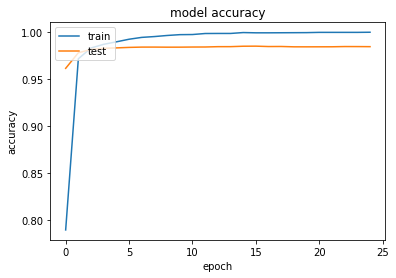

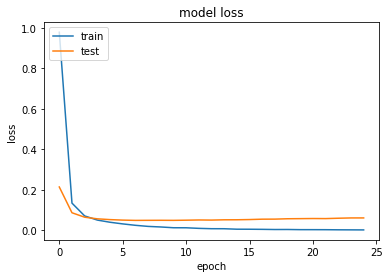

In [28]:
pred = X.reshape((X.shape[0], 1, X.shape[1]))



Y_pred_test = model.predict(pred)
y_pred_test = np.argmax(Y_pred_test, axis=1)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
print(accuracy_score(y, y_pred_test)*100)

#= summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()